### Divide Hugging Face Transformers training time by 2 or more

> *The basic idea behind the optimization is to avoid computations when we know we are going to throw its result.*

Smart Batching is the combination of two techniques--”Dynamic Padding” and “Uniform Length Batching”. Both have to do with cutting down the number of `[PAD]` tokens we have to add to our text, which results in faster training, and doesn’t seem to hurt accuracy!

In [23]:
import os
import gc
gc.enable()
import time
import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from transformers import (AdamW, 
                          BertTokenizerFast, 
                          BertModel, 
                          get_cosine_schedule_with_warmup)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler, SequentialSampler

import warnings
warnings.filterwarnings("ignore")

In [24]:
def good_update_interval(total_iters, num_desired_updates):
    exact_interval = total_iters / num_desired_updates
    order_of_mag = len(str(total_iters)) - 1
    round_mag = order_of_mag - 1
    update_interval = int(round(exact_interval, -round_mag))
    if update_interval == 0:
        update_interval = 1
    return update_interval

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
train_data = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test_data = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
sample_data = pd.read_csv('../input/contradictory-my-dear-watson/sample_submission.csv')

In [27]:
train_text = train_data[['premise', 'hypothesis']].values.tolist()
train_labels = train_data['label'].values.tolist()
test_text = test_data[['premise', 'hypothesis']].values.tolist()

print('{:,} Training Samples'.format(len(train_data)))
print('{:,} Test Samples'.format(len(test_data)))
print('Labels:', np.unique(train_data.label))

12,120 Training Samples
5,195 Test Samples
Labels: [0 1 2]


In [28]:
import textwrap
import random

wrapper = textwrap.TextWrapper(width=80) 
for i in range(3):
    j = random.choice(range(len(train_text)))
    print('==== Label: {:} ===='.format(train_labels[j]))
    print(wrapper.fill(" ".join(train_text[j])))
    print('')

==== Label: 2 ====
Sonra el abuelo derdi, Pues que recen y se acuesten (Eh, dua edip yatağa
gidelim). Dua etmemize gerek yok.

==== Label: 0 ====
and it just depends on how bad that person is It depends on the condition of the
person.

==== Label: 0 ====
Каним всяка нация да се присъедини към нас. Нуждаем се от помощ от цял свят.



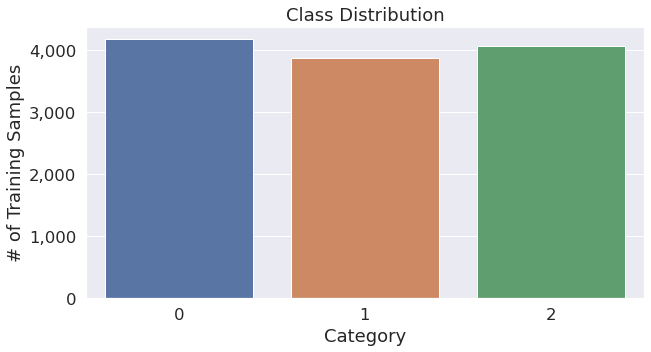

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)
ax = sns.countplot(train_labels)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')
import matplotlib as mpl
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

### Smart Batching

In [31]:
bert_model = "bert-base-multilingual-uncased"
tokenizer = BertTokenizerFast.from_pretrained(bert_model, do_lower_case=True)

In [32]:
max_len = 128
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_text)))
update_interval = good_update_interval(total_iters=len(train_text), num_desired_updates=10)
for text in train_text:    
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_len,  
                                 truncation=True,     
                                 padding=False)       
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 12,120 training samples...
  Tokenized 0 samples.
  Tokenized 1,000 samples.
  Tokenized 2,000 samples.
  Tokenized 3,000 samples.
  Tokenized 4,000 samples.
  Tokenized 5,000 samples.
  Tokenized 6,000 samples.
  Tokenized 7,000 samples.
  Tokenized 8,000 samples.
  Tokenized 9,000 samples.
  Tokenized 10,000 samples.
  Tokenized 11,000 samples.
  Tokenized 12,000 samples.
DONE.
    12,120 samples


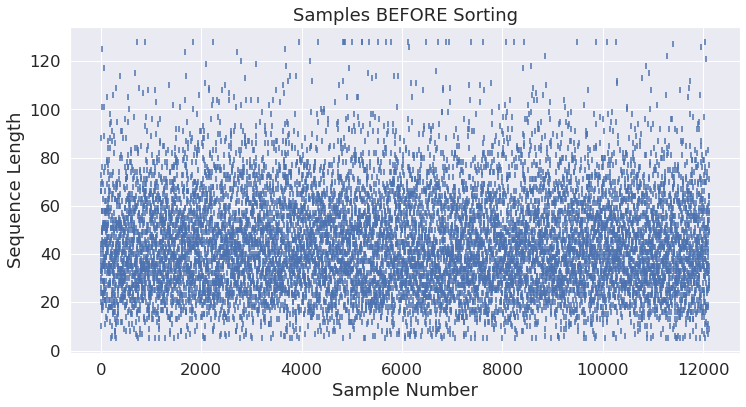

In [33]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")
plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')
plt.show()

In [34]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

Shortest sample: 5
Longest sample: 128


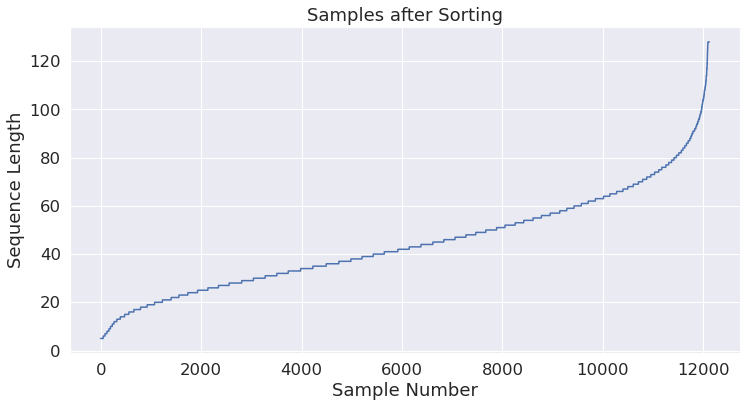

In [35]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(0, len(sorted_lengths)), sorted_lengths)
plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')
plt.show()

In [36]:
batch_size = 16
batch_ordered_sentences = []
batch_ordered_labels = []
print('Creating training batches of size {:}'.format(batch_size))
while len(train_samples) > 0:
    if ((len(batch_ordered_sentences) % 250) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))
    to_take = min(batch_size, len(train_samples))
    select = random.randint(0, len(train_samples) - to_take)
    batch = train_samples[select:(select + to_take)]
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])
    del train_samples[select:select + to_take]
print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 250 batches.
  Selected 500 batches.
  Selected 750 batches.

  DONE - 758 batches.


In [37]:
py_inputs = []
py_attn_masks = []
py_labels = []
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
    batch_padded_inputs = []
    batch_attn_masks = []
    max_size = max([len(sen) for sen in batch_inputs])
    for sen in batch_inputs:
        num_pads = max_size - len(sen)
        padded_input = sen + [tokenizer.pad_token_id]*num_pads
        attn_mask = [1] * len(sen) + [0] * num_pads
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))

In [38]:
padded_lengths = []
for batch in py_inputs:
    for s in batch:
        padded_lengths.append(len(s))
smart_token_count = np.sum(padded_lengths)
fixed_token_count = len(train_text) * max_len
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 
print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
   Fixed Padding: 1,551,360
  Smart Batching: 546,880  (64.7% less)


### Reduced to One Function

In [98]:
text_samples = train_text
labels = train_labels
tokenized_text = []
for t in tqdm(text_samples, total=len(text_samples)):
    input_ids = tokenizer.encode(t, 
                                 add_special_tokens=True, 
                                 max_length=max_len, 
                                 pad_to_max_length=False, 
                                 truncate=True)
    tokenized_text.append(input_ids)    
batch_size = 16
sorted_data = sorted(zip(tokenized_text, labels), key=lambda x: len(x[0]))
print("Shortest", len(sorted_data[0][0]))
print("Longest", len(sorted_data[-1][0]))

ordererd_batched_ids = []
ordererd_batched_labels = []
while len(sorted_data)>0:
    to_take = min(batch_size, len(sorted_data))
    select = random.randint(0, len(sorted_data)-to_take)
    batch = sorted_data[select:select+to_take]
    ordererd_batched_ids.append([s[0] for s in batch])
    ordererd_batched_labels.append([s[1] for s in batch])
    del sorted_data[select:select+to_take]
print(len(ordererd_batched_ids))

py_inputs = []
py_attn_masks = []
py_labels = []

for (batch_inputs, batch_labels) in tqdm(zip(ordererd_batched_ids, ordererd_batched_labels), total=len(ordererd_batched_ids)):
    batch_padded_inputs = []
    batch_attn_masks = []
    max_size = max([len(sen) for sen in batch_inputs])
    for sen in batch_inputs:
        num_pads = max_size - len(sen)
        padded_input = sen + [tokenizer.pad_token_id]*num_pads
        attn_mask = [1] * len(sen) + [0] * num_pads
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))

 47%|████▋     | 359/758 [00:00<00:00, 3584.37it/s]

Shortest 5
Longest 128
758


100%|██████████| 758/758 [00:00<00:00, 3546.69it/s]


In [99]:
padded_lengths = []
for batch in py_inputs:
    for s in batch:
        padded_lengths.append(len(s))

smart_token_count = sum(padded_lengths)
fixed_token_count = 128*len(train_text)
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Smart padding', smart_token_count)
print('Fixed padding', fixed_token_count)
print('Total reduction {:1%}'.format(prcnt_reduced))

Smart padding 547064
Fixed padding 1551360
Total reduction 64.736489%


In [1]:
import tensorflow as tf
try:
   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
   tpu = None
if tpu:
   tf.config.experimental_connect_to_cluster(tpu)
   tf.tpu.experimental.initialize_tpu_system(tpu)
   strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
   strategy = tf.distribute.get_strategy()

Running on TPU  ['10.0.0.2:8470']


In [2]:
!pip install git+https://github.com/ssut/py-googletrans.git
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly  --apt-packages libomp5 libopenblas-dev

  Cloning https://github.com/ssut/py-googletrans.git to /tmp/pip-req-build-fd26klh0
  Running command git clone -q https://github.com/ssut/py-googletrans.git /tmp/pip-req-build-fd26klh0
     |████████████████████████████████| 55 kB 290 kB/s eta 0:00:011
     |████████████████████████████████| 930 kB 944 kB/s eta 0:00:01
     |████████████████████████████████| 42 kB 722 kB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.2 MB/s eta 0:00:011
     |████████████████████████████████| 65 kB 1.6 MB/s eta 0:00:011
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=16448 sha256=0056e5e541322167429cb918dbef85eac69c57123462ce67dc9a114ed8edb122
  Stored in directory: /tmp/pip-ephem-wheel-cache-98uckjbd/wheels/eb/82/a2/f07ad36dbee6290000d9057df7e3c81a973db81913efd3b252
Successfully built googletrans
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  % Total    % Received % Xferd  Average Speed   Time  

update-alternatives: using /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3 to provide /usr/lib/x86_64-linux-gnu/libblas.so.3 (libblas.so.3-x86_64-linux-gnu) in auto mode
update-alternatives: using /usr/lib/x86_64-linux-gnu/openblas/liblapack.so.3 to provide /usr/lib/x86_64-linux-gnu/liblapack.so.3 (liblapack.so.3-x86_64-linux-gnu) in auto mode
Setting up libopenblas-dev:amd64 (0.2.20+ds-4) ...
update-alternatives: using /usr/lib/x86_64-linux-gnu/openblas/libblas.so to provide /usr/lib/x86_64-linux-gnu/libblas.so (libblas.so-x86_64-linux-gnu) in auto mode
update-alternatives: using /usr/lib/x86_64-linux-gnu/openblas/liblapack.so to provide /usr/lib/x86_64-linux-gnu/liblapack.so (liblapack.so-x86_64-linux-gnu) in auto mode
Processing triggers for libc-bin (2.27-3ubuntu1) ...


In [3]:
%%time
%autosave 60

import os
os.environ['XLA_USE_BF16'] = "1"
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

import gc
gc.enable()
import time
import random 

import numpy as np
import pandas as pd
from tqdm import tqdm 
from googletrans import Translator
from dask import bag, diagnostics

import transformers
from transformers import (AdamW, 
                          XLMRobertaTokenizer, 
                          XLMRobertaModel, 
                          get_cosine_schedule_with_warmup)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.serialization as xser
import torch_xla.version as xv

import warnings
warnings.filterwarnings("ignore")

print('PYTORCH:', xv.__torch_gitrev__)
print('XLA:', xv.__xla_gitrev__)

Autosaving every 60 seconds


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


PYTORCH: b6810c1064eb24cb542a9be56140689dce8ad7a1
XLA: 2c732f20b5343dd1a694cd69cd15dd7f76ee1028
CPU times: user 1.64 s, sys: 248 ms, total: 1.89 s
Wall time: 2.95 s


In [4]:
train = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
sample_submission = pd.read_csv('../input/contradictory-my-dear-watson/sample_submission.csv')

### DataLoader - More Formal way in Torch

In [152]:
def load_data(data, sort, tokenizer):
    sentences = list()
    texts = data[['premise','hypothesis']].values.tolist()
    labels = data.label
    
    for (text, label) in zip(texts, labels):
        text = " ".join(text)
        ids = tokenizer.encode(text,
                               add_special_tokens=True,
                              )
        lab = len(ids)
        sentences.append((lab, text, label))
    if sort:
        sentences.sort(key=lambda x: x[0])
    return sentences

def build_batches(sentences, batch_size):
    batch_ordered_sentences = list()
    while len(sentences) > 0:
        to_take = min(batch_size, len(sentences))
        select = random.randint(0, len(sentences) - to_take)
        batch_ordered_sentences += sentences[select:select + to_take]
        del sentences[select:select + to_take]
    return batch_ordered_sentences

class TextDataset(Dataset):
    def __init__(self,
                 data,
                 tokenizer,
                 max_length):       
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_length

    def encode(self, example):
        encoded_dict = self.tokenizer.encode_plus(text=example,
                                                  padding=False,
                                                  truncation=True,
                                                  add_special_tokens=True,
                                                  max_length=self.max_len,
                                                  pad_to_max_length=False,
                                                  return_token_type_ids=False,
                                                  return_attention_mask=False,
                                                  return_position_ids=False,
                                                  return_overflowing_tokens=False,
                                                  return_special_tokens_mask=False,
                                                 )
        return encoded_dict['input_ids']

    def __getitem__(self, idx):
        data = self.data[idx]
        lab, text, label = data
        ids = self.encode(text)
        return ids, label

    def __len__(self):
        return len(self.data)
    
def pad_seq(seq, max_batch_len, pad_value):
    return seq + (max_batch_len - len(seq)) * [pad_value]

def collate_batch(batch):
    batch_inputs = list()
    batch_attention_masks = list()
    batch_labels = list()
    input_ids, labels = zip(*batch)
    max_size = max([len(ids) for ids in input_ids])
    for (ids, label) in zip(input_ids, labels):
        batch_inputs += [pad_seq(ids, max_size, tokenizer.pad_token_id)]
        batch_attention_masks += [[1] * len(ids) + [0] * (max_size - len(ids))]
        batch_labels.append(label)
    return {"input_ids": torch.tensor(batch_inputs),
            "attention_mask": torch.tensor(batch_attention_masks),
            "labels": torch.tensor(batch_labels)
            }

In [118]:
class XLMRoberta(nn.Module):
    def __init__(self, num_labels, multisample):
        super(XLMRoberta, self).__init__()
        output_hidden_states = False
        self.num_labels = num_labels
        self.multisample= multisample
        self.roberta = XLMRobertaModel.from_pretrained("xlm-roberta-large", 
                                                       output_hidden_states=output_hidden_states, 
                                                       num_labels=1)
        self.layer_norm = nn.LayerNorm(1024*2)
        self.dropout = nn.Dropout(p=0.2)
        self.high_dropout = nn.Dropout(p=0.5)        
        self.classifier = nn.Linear(1024*2, self.num_labels)
    
    def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None):
        outputs = self.roberta(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask,
                               inputs_embeds=inputs_embeds)
        average_pool = torch.mean(outputs[0], 1)
        max_pool, _ = torch.max(outputs[0], 1)
        concatenate_layer = torch.cat((average_pool, max_pool), 1)
        normalization = self.layer_norm(concatenate_layer)
        if self.multisample:
            # Multisample Dropout
            logits = torch.mean(
                torch.stack(
                    [self.classifier(self.dropout(normalization)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        else:
            logits = self.dropout(normalization)
            logits = self.classifier(logits)       
        outputs = logits
        return outputs  

In [146]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [147]:
def get_model_optimizer(model):
    # Differential Learning Rate
    def is_backbone(name):
        return "roberta" in name
    
    optimizer_grouped_parameters = [
       {'params': [param for name, param in model.named_parameters() if is_backbone(name)], 'lr': LR},
       {'params': [param for name, param in model.named_parameters() if not is_backbone(name)], 'lr': 1e-3} 
    ]
    
    optimizer = AdamW(
        optimizer_grouped_parameters, lr=LR, weight_decay=1e-2
    )
    
    return optimizer

In [148]:
def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

In [160]:
def train_loop_fn(train_loader, model, optimizer, device, scheduler, epoch=None):
    # Train
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1],
        prefix="[xla:{}]Train:  Epoch: [{}]".format(xm.get_ordinal(), epoch)
    )
    model.train()
    end = time.time()
    for i, data in enumerate(train_loader):
        data_time.update(time.time()-end)
        ids = data["input_ids"]
        mask = data["attention_mask"]
        targets = data["labels"]
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(
            input_ids = ids,
            attention_mask = mask
        )
        loss = loss_fn(outputs, targets)
        loss.backward()
        xm.optimizer_step(optimizer)
        loss = loss_fn(outputs, targets)
        acc1= accuracy(outputs, targets, topk=(1,))
        losses.update(loss.item(), ids.size(0))
        top1.update(acc1[0].item(), ids.size(0))
        scheduler.step()
        batch_time.update(time.time() - end)
        end = time.time()
        if i % 30 == 0:
            progress.display(i)
    del loss
    del outputs
    del ids
    del mask
    del targets
    gc.collect()

In [161]:
def eval_loop_fn(validation_loader, model, device):
    #Validation
    model.eval()
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    learning_rate = AverageMeter('LR',':2.8f')
    progress = ProgressMeter(
        len(validation_loader),
        [batch_time, losses, top1],
        prefix='[xla:{}]Validation: '.format(xm.get_ordinal()))
    with torch.no_grad():
        end = time.time()
        for i, data in enumerate(validation_loader):
            ids = data["input_ids"]
            mask = data["attention_mask"]
            targets = data["labels"]
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            outputs = model(
                input_ids = ids,
                attention_mask = mask
            )
            loss = loss_fn(outputs, targets)
            acc1= accuracy(outputs, targets, topk=(1,))
            losses.update(loss.item(), ids.size(0))
            top1.update(acc1[0].item(), ids.size(0))
            batch_time.update(time.time() - end)
            end = time.time()
            if i % 10 == 0:
                progress.display(i)
    del loss
    del outputs
    del ids
    del mask
    del targets
    gc.collect()

In [164]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 15
MAX_LEN = 128
# Scale learning rate to 8 TPU's
LR = 2e-5 * xm.xrt_world_size() 
METRICS_DEBUG = True

WRAPPED_MODEL = xmp.MpModelWrapper(XLMRoberta(num_labels=3, multisample=False))
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [165]:
mask = np.random.rand(len(train)) < 0.95
train_df = train[mask]
valid_df = train[~mask]

train_sentences = load_data(train_df, sort=True, tokenizer=tokenizer)
train_batches = build_batches(train_sentences, batch_size=TRAIN_BATCH_SIZE)
train_dataset = TextDataset(train_batches, tokenizer, max_length=MAX_LEN)

valid_sentences = load_data(valid_df, sort=True, tokenizer=tokenizer)
valid_batches = build_batches(valid_sentences, batch_size=VALID_BATCH_SIZE)
valid_dataset = TextDataset(valid_batches, tokenizer, max_length=MAX_LEN)

In [166]:
def _run():
    xm.master_print('Starting Run ...')
    
    train_sampler = DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        sampler=train_sampler,
        collate_fn=collate_batch,
        num_workers=4
    )
    xm.master_print('Train Loader Created.')
    
    valid_sampler = DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        sampler=valid_sampler,
        collate_fn=collate_batch,
        num_workers=4
    )
    xm.master_print('Valid Loader Created.')
    
    num_train_steps = int(len(train_df) / TRAIN_BATCH_SIZE / xm.xrt_world_size())
    device = xm.xla_device()
    model = WRAPPED_MODEL.to(device)
    xm.master_print('Done Model Loading.')
    optimizer = get_model_optimizer(model)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = num_train_steps * EPOCHS
    )
    xm.master_print(f'Num Train Steps= {num_train_steps}, XRT World Size= {xm.xrt_world_size()}.')
    
    for epoch in range(EPOCHS):
        para_loader = pl.ParallelLoader(train_data_loader, [device])
        xm.master_print('Parallel Loader Created. Training ...')
        train_loop_fn(para_loader.per_device_loader(device),
                      model,  
                      optimizer, 
                      device, 
                      scheduler, 
                      epoch
                     )
        
        xm.master_print("Finished training epoch {}".format(epoch))
            
        para_loader = pl.ParallelLoader(valid_data_loader, [device])
        xm.master_print('Parallel Loader Created. Validating ...')
        eval_loop_fn(para_loader.per_device_loader(device), 
                     model,  
                     device
                    )
        
        # Serialized and Memory Reduced Model Saving
        if epoch == EPOCHS-1:
            xm.master_print('Saving Model ..')
            xser.save(model.state_dict(), f"model.bin", master_only=True)
            xm.master_print('Model Saved.')
            
    if METRICS_DEBUG:
      xm.master_print(met.metrics_report(), flush=True)

In [167]:
def _mp_fn(rank, flags):
    # torch.set_default_tensor_type('torch.FloatTensor')
    _run()

FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

Starting Run ...
Train Loader Created.
Valid Loader Created.
Done Model Loading.
Num Train Steps= 89, XRT World Size= 8.
Parallel Loader Created. Training ...
[xla:2]Train:  Epoch: [0][ 0/90]	Time 42.225 (42.225)	Data  0.377 ( 0.377)	Loss 1.1406e+00 (1.1406e+00)	Acc@1  31.25 ( 31.25)
[xla:3]Train:  Epoch: [0][ 0/90]	Time 19.190 (19.190)	Data  0.383 ( 0.383)	Loss 1.1094e+00 (1.1094e+00)	Acc@1  43.75 ( 43.75)
[xla:6]Train:  Epoch: [0][ 0/90]	Time 36.406 (36.406)	Data  0.360 ( 0.360)	Loss 1.1328e+00 (1.1328e+00)	Acc@1  25.00 ( 25.00)
[xla:4]Train:  Epoch: [0][ 0/90]	Time 13.489 (13.489)	Data  0.384 ( 0.384)	Loss 1.1094e+00 (1.1094e+00)	Acc@1  37.50 ( 37.50)
[xla:7]Train:  Epoch: [0][ 0/90]	Time 24.966 (24.966)	Data  0.381 ( 0.381)	Loss 1.1562e+00 (1.1562e+00)	Acc@1  37.50 ( 37.50)
[xla:5]Train:  Epoch: [0][ 0/90]	Time  7.194 ( 7.194)	Data  0.356 ( 0.356)	Loss 1.0703e+00 (1.0703e+00)	Acc@1  37.50 ( 37.50)
[xla:1]Train:  Epoch: [0][ 0/90]	Time 30.680 (30.680)	Data  0.384 ( 0.384)	Loss 1.117

Exception: process 5 terminated with signal SIGKILL

In [132]:
train_sentences = load_data(train_df, sort=True, tokenizer=tokenizer)
train_batches = build_batches(train_sentences, batch_size=16)
dataset = TextDataset(train_batches, tokenizer, max_length=128)
loader = DataLoader(dataset, batch_size=16, collate_fn=collate_batch, shuffle=False, num_workers=4)`

In [106]:
dynamic_padding  = sum(total)
fixed_padding = len(train_text)*128
reduction_percnt = (fixed_padding - dynamic_padding) / float(fixed_padding)
print('{:.1%} reduction.'.format(reduction_percnt))

64.8% reduction.


In [ ]:
def make_smart_batches(text_samples, labels, batch_size):
    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))
    full_input_ids = []
    print('Tokenizing {:,} samples...'.format(len(labels)))
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=15)
    for text in text_samples:
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))
        input_ids = tokenizer.encode(text=text,              
                                    add_special_tokens=True, 
                                    max_length=max_len,      
                                    truncation=True,         
                                    padding=False)           
        full_input_ids.append(input_ids)
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))
    print('{:>10,} samples after sorting\n'.format(len(samples)))
    import random
    batch_ordered_sentences = []
    batch_ordered_labels = []
    print('Creating batches of size {:}...'.format(batch_size))
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    while len(samples) > 0:
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))
        to_take = min(batch_size, len(samples))
        select = random.randint(0, len(samples) - to_take)
        batch = samples[select:(select + to_take)]
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])
        del samples[select:select + to_take]
    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))
    print('Padding out sequences within each batch...')
    py_inputs = []
    py_attn_masks = []
    py_labels = []
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
        batch_padded_inputs = []
        batch_attn_masks = []
        max_size = max([len(sen) for sen in batch_inputs])
        for sen in batch_inputs:
            num_pads = max_size - len(sen)
            padded_input = sen + [tokenizer.pad_token_id]*num_pads
            attn_mask = [1] * len(sen) + [0] * num_pads
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    print('  DONE.')
    return (py_inputs, py_attn_masks, py_labels)

py_inputs, py_attn_masks, py_labels = make_smart_batches(train_text, train_labels, batch_size=16)